
# PCB - Ingestion Data Pipeline 

This is the pipeline we will be building. We ingest 2 datasets, namely:

* The raw images (jpg) containing PCB
* The label, the type of anomalies saved as CSV files

We will first focus on building a data pipeline to incrementally load this data and create a final Gold table.

This table will then be used to train a ML Classification model to learn to detect anomalies in our images in real time!

*Note that this demo leverages the standard spark API. You could also implement this same pipeline in pure SQL leveraging Delta Live Tables. For more details on DLT, install `dbdemos.install('dlt-loans)`*

<!-- Collect usage data (view). Remove it to disable collection. View README for more details.  -->
<img width="1px" src="https://ppxrzfxige.execute-api.us-west-2.amazonaws.com/v1/analytics?category=data-science&org_id=1549883858499596&notebook=%2F01-ingestion-and-ETL&demo_name=computer-vision-pcb&event=VIEW&path=%2F_dbdemos%2Fdata-science%2Fcomputer-vision-pcb%2F01-ingestion-and-ETL&version=1">

### A cluster has been created for this demo
To run this demo, just select the cluster `dbdemos-computer-vision-pcb-shawnzou2020` from the dropdown menu ([open cluster configuration](https://dbc-abdbb8e0-f50f.cloud.databricks.com/#setting/clusters/0410-040209-qt57lxc5/configuration)). <br />
*Note: If the cluster was deleted after 30 days, you can re-create it with `dbdemos.create_cluster('computer-vision-pcb')` or re-install the demo: `dbdemos.install('computer-vision-pcb')`*

In [0]:
%run ./_resources/00-init $reset_all_data=false $db=dbdemos $catalog=manufacturing_pcb

USE CATALOG `manufacturing_pcb`
using cloud_storage_path /Users/quentin.ambard@databricks.com/demos/manufacturing_pcb_dbdemos
using catalog.database `manufacturing_pcb`.`dbdemos`


data already existing. Run with reset_all_data=true to force a data cleanup for your local demo.


## Reviewing the incoming dataset

The dataset was downloaded for you automatically and is available in cloud your dbfs storage folder. Let's explore the data:

In [0]:
%fs ls /dbdemos/manufacturing/pcb/Images/Normal/

path,name,size,modificationTime
dbfs:/dbdemos/manufacturing/pcb/Images/Normal/0000.JPG,0000.JPG,260513,1687201348000
dbfs:/dbdemos/manufacturing/pcb/Images/Normal/0001.JPG,0001.JPG,271930,1687201193000
dbfs:/dbdemos/manufacturing/pcb/Images/Normal/0002.JPG,0002.JPG,275133,1687201278000
dbfs:/dbdemos/manufacturing/pcb/Images/Normal/0003.JPG,0003.JPG,269367,1687201235000
dbfs:/dbdemos/manufacturing/pcb/Images/Normal/0004.JPG,0004.JPG,277847,1687201319000
dbfs:/dbdemos/manufacturing/pcb/Images/Normal/0005.JPG,0005.JPG,284472,1687201214000
dbfs:/dbdemos/manufacturing/pcb/Images/Normal/0006.JPG,0006.JPG,270701,1687201297000
dbfs:/dbdemos/manufacturing/pcb/Images/Normal/0007.JPG,0007.JPG,262093,1687201255000
dbfs:/dbdemos/manufacturing/pcb/Images/Normal/0008.JPG,0008.JPG,278499,1687201342000
dbfs:/dbdemos/manufacturing/pcb/Images/Normal/0009.JPG,0009.JPG,270083,1687201205000


In [0]:
%fs ls /dbdemos/manufacturing/pcb/labels

path,name,size,modificationTime
dbfs:/dbdemos/manufacturing/pcb/labels/image_anno.csv,image_anno.csv,49477,1687201355000


### PCB images inspection

We can display images with `matplotlib` in a native python way.

Let us investigate what a normal image looks like, and then one with an anomaly.

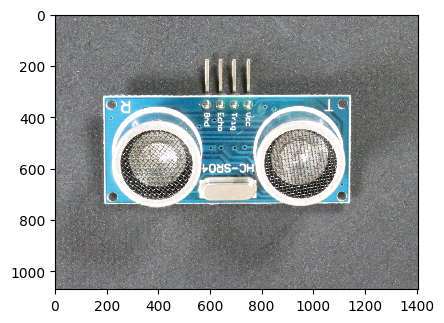

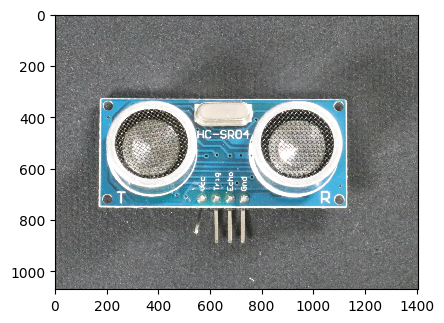

In [0]:
from PIL import Image
import matplotlib.pyplot as plt

def display_image(path, dpi=300):
    img = Image.open(path)
    width, height = img.size
    plt.figure(figsize=(width / dpi, height / dpi))
    plt.imshow(img, interpolation="nearest", aspect="auto")


display_image("/dbfs/dbdemos/manufacturing/pcb/Images/Normal/0000.JPG")
display_image("/dbfs/dbdemos/manufacturing/pcb/Images/Anomaly/000.JPG")

## Ingesting raw images with Databricks Autoloader

<img src="https://github.com/databricks-demos/dbdemos-resources/blob/main/images/product/computer-vision/deeplearning-cv-pcb-flow-1.png?raw=true" width="700px" style="float: right"/>

The first step is to load the individual JPG images. This can be quite challenging at scale, especially for incremental load (consume only the new ones).

Databricks Autoloader can easily handle all type of format and make it very easy to ingest new datasets.

Autoloader will guarantee that only new files are being processed while scaling with millions of individual images. 

### Load binary files with Auto Loader

We can now use the Auto Loader to load images, and a spark function to create the label column. Autoloader will automatically create the table and tune it accordingly, disabling compression for binary among other.

We can also very easily display the content of the images and the labels as a table.

In [0]:
(spark.readStream.format("cloudFiles")
                 .option("cloudFiles.format", "binaryFile")
                 .option("pathGlobFilter", "*.JPG")
                 .option("recursiveFileLookup", "true")
                 .option("cloudFiles.schemaLocation", "/dbdemos/manufacturing/pcb/stream/pcb_schema")
                 .load(f"/dbdemos/manufacturing/pcb/Images/")
    .withColumn("filename", F.substring_index(col("path"), "/", -1))
    .writeStream.trigger(availableNow=True)
                .option("checkpointLocation", f"/dbdemos/manufacturing/pcb/stream/pcb_checkpoint")
                .toTable("pcb_images").awaitTermination())

spark.sql("ALTER TABLE pcb_images OWNER TO `account users`")
display(spark.table("pcb_images"))

path modificationTime length content filename dbfs:/dbdemos/manufacturing/pcb/Images/Normal/0606.JPG 2024-02-23T19:25:26.000+0000 266743 List(/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjI= (truncated), iVBORw0KGgoAAAANSUhEUgAAAGQAAABMCAIAAAAUf4VYAABBs0lEQVR42k28B3dVV7YuqH/Qo9/oHqPf6H79Rt++79atcrnKVbaxSTZRgAChHM9RODnnnCUBAiEJFFFOKABCKEugjECIbAMmm2hyEEFZAr/+5lq4Rh/2OGzts8Na35rhm2vPuYIsVrvJbDVbbBaL1el02e1Om81hNlux4/X6jUaz1ebAOfi2O1wujzsQSHe6PC63F984iG+b3YnTDAYTLnQ6vdgcTg/d1mLz+dN8vgCOW612t9vr8fjw7XDgzl632+20O9wuD07AfQNpGTaHy+Jwmu0ObGiSx+vH5TYHTneaTCbcAY82mIxOt8vudJgsZnzb7Xar1Wo0GnE3g8Fgs9l8Pj9uaLHacDU7gXqBzeP1We343eb1+cxmM27iTwvwWzndbnQH//EOopkut9vj9Xq8HjzbZLK4XIDFDgCCdHojkEK3jUYTzrFYbOg2LsJjAgE81erEqQ70y4XbOZ1OPMlmt1tsuNjl9vgAit5gcrLzsTlwGm0EB77NuLWNWgz0//gJLQGgTqfD7fX68CAcARD8cuCO2wIsK9tH4zV6HRAFAuiq3mgwmk1Wm83tQV+8VroMQ2tjtyXg0tLTrDa7wcjO8Xqw4fkcCDMwNaOdTvQILXC40AUrtkB6Ok5A99EXbOgIhoHjZUMfbXY0krqFj8sZZDRBpOwarZ7uCDEi6QAoLo4LRpJ+tzl4n7FZLBb8pNcbrExeqKkYINZn7GPHinsATSv97/f77ei00wmZwm1JOtLSXR4PPYKJJPrmcuE4CTVuhCN2l9dqd0GynC53WkY6+mN12DDgZnTNYSeBwp+4BuLgcqHBdC06ZrdZrBZIEzacg3ZBGHGOPwAs8HAf+s8vt5Jg2KBLbo8begGAABZED+3hONJAuiAheKaHxtDptNjMgfQ0k9USBKRYo0nXmAQBApvHgz5DFhxanc5mJ61EKzCcBIzbbbYQpnzEOFjsnoQ1BJPhAqHAI9EUN5A0WnFvB457fQGPzw+w8CeuwKXoOW8emoU7G40Wt8vrcvuhBuibGQPjdsFCoOFopsvr8Qe8FovZ5aLz0UUMCxqjg1LYLCab2e6yuz0us8VEcut2s5F3oSUQDVyO+6ATGA5IKI4YTRAEs5MpHkYR0ODjYmOAjgNSaJ4H0umFelohux6fJ8hI4mNiGuvE+YDLBvm0mKn3TCtxI0iN3x9Az4Agmoi2MUkm6TAy4+L3p6Wlb+cmDENCjXdAuGywFHYSYIy8AwaIDbLfDstIsuhm50ChLcAUowpzwx6UBqk3mox29gHigAyCo9PrcL7PhyZZcEsIDu8VwIKxNNtsRovR5rQZjBB6PbpgMkM6SRJ8/gAUEP3AfSBQeqPeZrd+tlZsPHEBurY9YzspcloaOujz+aDdRpOBoHZDw0xpGVBwC2yWHndBxzDgOqNeZ9ABSwcNOGkNU0k3tykmE4bUhVYSXiYTTAPuhFPszHgBCzKiGCKfH8pBLSNZJStmMpr1OiMkESdAOix2m5NJCkkfLLwXV/hoWN2knkAGj0BXMTB4HBqNwYZBQAuM7MOOcB006/V61nZmJ+xWkimySjhm4abaQqhRSzC62HGSKce1sFBu0lMMksWCHZIp9oGa8EEKBPxGkx4KSDJFqgAxtQRptVqDXk+j7/Hq4FGMBggW+QcSY+YBmfEG3PALGEm1Wm1mti1jx3YyZtBEDD+agM3DzDwU2QZB0JMbI3OGO3m1Wj1TW/oLJ/gCfq8P/tRlY7KD1gAxaDofGFgQO8mOGd3QaFQGvQ7IAyYuTRgqfANKNBYtIWAssEVGgsBNbgvPMBiNzNqaSX7tZOOAGCQOfTZZcCc9jbXRgIsdTkcgkIbbQOahtegmt55QZJ1O4/XBRcBoW+B1gWcQjZXls60hK25zQgp0OgPardUZoGJkoF2QNbICeISZfdB/yA024hDMcmHDCbgPzkbfmX23U899Ae4rycz6AtiBovGR5O6P2zvyzFbaMCSEvS+AR1AnIZYm2Al6LrEEqCdsGTyyjQQQMDHIoLPAweJykk/HwBhM5IahhgDczT42Gj8dkCIW4SWXYiOzSc5UpyNZ0euNzFO7mWABX/QIGJEUgxU4SQZsQWZYOaMJz8LA8OYCLzQMGxoDsCAOzIfamId0ajQadBV/41dOYazEhVyACfbX5/F73T6b1c6NPfgXNg4HWBL5eDtRB1zF+BOZXguNhpu7DjSdax8bTDukHooGOPgODmr1OitrCf6EKVGrleiDXq8FoAaMMHy01YoLOFoQLQDKuAV9rGwAYcnIVzA7AEtCHYMtt9r5cwMBKJABYwC3g7bgWow02BX/NQhNAQjokslocbBxpgGD3NPY2DhRgLKg12qtmsykmTTCQA3So9FkYs1m3hQPDJIL+AUc/z/nyJsKWWM+gdDx+cmQMx6XRuzFhcEkqST4XE5chGGC5GHDwOp0OrREp9VDvNAMrQ7+WcfUUwO8mDLif71Wq8G+Sq22MfbIaSoaxkgGvxlEAQaGHJSdWJCD3IsNlMWBnjPSSx/IAdDn3bGzPSBuZTjgSBDDxUyukHlQYqfQdTMfBhvvK06ADOMIdpj1xZ/gWXbOIWzkLZ2Ml8GjBawWupmFOQfbH0KHDpOu2R1qjQ5UC5IFS4VfuWJCQ61MPtVaDbc1eBwg0xt03LgYdHqbyYJvrZrgAhaQNbVapVQqYFlUKhVJH9QJBhdEyG6XSCXEjyywRHBtMIVQZ1Ig2GAT8xKOz6PCrB2TDowBQDcRnzBCRBn1IxrIoWAomYIgKDjLRO6GzK+dQg2LWq0lzmCzcvrjZETNQOYfdN/COmOAM7OCo3+2XB4nYxJE7aBW9CfbSL9gkv1mxjDQcqggGygbs2s0NmaKGYzMoIDEABCdQqWEoMuVCo1WLZGKZDJJakqyTCbTQpw0WqlMJpfLARY6JpNJoYlADW7HxHBlxJAoMYVfduL6nDXbGE1l5A/GnqiDkXELPBQjpCX5JQ8ApDBaAN3AMAXCAJHbAYxZEFAjr2wyMZ7lZXEDWVlSZHLSFB/hJysNGYgrxRx6g5FIP+IkiCGLK4EPjkBMYJjhQIkXsRjTxogFvAKAw0+83VbysfREaAhAV2v1gqQkqUKKPmp1GoFAoIIlctrEUnG8IAF2zGzQpQoSpRKxVAqgZBotiRI+EAR8QwEVChm3DBogCBm2E+1C69Q6HRSbWu6gvsDRU/9J68yAB0830i4uMENcAbcSt1OrcIQjhVtq1GqJWALjpVKqMEJQQ1g4YkMQGsBB8ZeJbokjEAcQKE4OaPzZWJAHMluxr4U4GIyIkyD9ehZOElhePw8YzeQWidUQef8c3IDdeICU2WbFHvl8m7Wj9bBSq4kTCCBNw32tUqk4OTnZYTP0d9RLxCKBIL6hurCxujwxIV4mFUO55HIZviUyKWRMrdEoldQ9QKzWqKE7EEYDKZEBYJmsdgwpIINWU5fMJiKrZNQJIAg19AlSo1Ao6FZqtUwq0+kgQLSPX/C/QQ9SpYWqK+UyAIkfgjjhRFfJA1o+ewpYIZKEACJ4P5MyB3cuEARAw6gx3ApJn55NNkBUiYrzQJp9c97vYb6SCSmG18EsPrwVKTMGAP7rwqnjBr0GkiVKSR0f6VYqRBER4XaLfqSn

### Load CSV label files with Auto Loader
CSV files can easily be loaded using Databricks [Auto Loader](https://docs.databricks.com/ingestion/auto-loader/index.html), including schema inference and evolution.

In [0]:
(spark.readStream.format("cloudFiles")
                 .option("cloudFiles.format", "csv")
                 .option("header", True)
                 .option("cloudFiles.schemaLocation", "/dbdemos/manufacturing/pcb/stream/labels_schema")
                 .load(f"/dbdemos/manufacturing/pcb/labels/")
      .withColumn("filename", F.substring_index(col("image"), "/", -1))
      .select("filename", "label")
      .withColumnRenamed("label", "labelDetail")
      .writeStream.trigger(availableNow=True)
                  .option("checkpointLocation", "/dbdemos/manufacturing/pcb/stream/labels_checkpoint")
                  .toTable("pcb_labels").awaitTermination())

spark.sql("ALTER TABLE pcb_labels OWNER TO `account users`")
display(spark.table("pcb_labels"))

filename,labelDetail
0000.JPG,normal
0001.JPG,normal
0002.JPG,normal
0003.JPG,normal
0004.JPG,normal
0005.JPG,normal
0006.JPG,normal
0007.JPG,normal
0008.JPG,normal
0009.JPG,normal


## Let's now merge the labels and the images tables

<img src="https://github.com/databricks-demos/dbdemos-resources/blob/main/images/product/computer-vision/deeplearning-cv-pcb-flow-2.png?raw=true" width="700px" style="float: right"/>

Note that we're working with delta tables to make the ingestion simple. 

You don't have to worry about individual small images anymore.

We can do the join operation either in python or SQL.

In [0]:
%sql
CREATE OR REPLACE TABLE training_dataset AS 
  (SELECT 
    *, CASE WHEN labelDetail = 'normal' THEN 'normal' ELSE 'damaged' END as label
    FROM pcb_images INNER JOIN pcb_labels USING (filename)) ;

ALTER TABLE training_dataset OWNER TO `account users`;

SELECT * FROM training_dataset LIMIT 10;

filename path modificationTime length content labelDetail label 0721.JPG dbfs:/dbdemos/manufacturing/pcb/Images/Normal/0721.JPG 2024-02-23T15:03:34.000+0000 280232 List(/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjI= (truncated), iVBORw0KGgoAAAANSUhEUgAAAGQAAABMCAIAAAAUf4VYAABAU0lEQVR42k2891tU2dI2zN/yvb98z/U9c86Z0Rl1zGJEkJxz7KYb6G4659xNzkqSjGSQnBEwgwHBwJjzBMM4JhQM57trLWeut6/tdnezw1r3qrqrau1V5aFQKLRarUqlUigVGp1WqVapNGq5UqFWK1Xsk6mQS2Qyrc6g1xt1OoNGo1OrcYXeYDCp1GqJTJqZmYmbmEwmjUaj1+td7iy5QqXW6rR6nK5XazVqjdZoNGs0Wh37yGSyzEy5QqHCyTjWs4/BYOAHOEEuV2rxPIMR56A1uBaPwzH/Xa1Wo516o0GlVvFL8HTcRy6X409KpRK3woHVasXj+RMVikwNTtbqlHI6E+fo9Vo022w2Z2Vl4Rk4B1/5tegbDvAjnqVQ0AHuxnHwwB3RMDwfPUALsKGTaoYH4EpLS2OI4auetZUwQuuNJotGq8fPuBt+BI64QqlU22x2vcGIc7CXSDP1BhNujgvlchoSLTsVvUI/tdQHBZrIW4OW4XKMBPZoMVoPACUSGR8b/EgdUKtxLa7CqNAJaKzRaLPZZFIZbzBHHMcAGk2yWGy4UCqVqZRKPChTlqlk8NOtTUYVDaKWjQ2hjNviGA3Ec+x2O+6sZh/8leOI8z0yJDL0CmABQzwYDfrWAZVao1LrtDqLxWI0mjLlaKsWAOFMgCWnpmt0eiN+VDFBM+pNRoPZZDQxKYGcWfjJeiaAGEN0g48h2oFfcT+SYpVKIpHgR+whcOgGbgaxk2bKMiQSHDBZ1nKBgpyazCadnu6A1nPocQcaK/YLl1Azk3F0XkV7Je5Mw6NS8T36jOdCNnEAsaChZ9fiEnZPnYZ9cDLuRhLDpBV3w1UeuCdAYzLyTeS+ga0i4eMtYLhpcRr0C1dBBtFTg9GIbqCdaDM2jUprJPlSM3XTU6M0GovNhs7L2MjgwyEjLM0WDCtajGHnwsJ0k9SZBlMhAyfgobgVvgJ4Ps6ACS3WMcEn1VCrcY3RZCQB0etxP66VvIe4HBSh4Jqs0TgcDpyPPmbKqfG4CREBCbj2mxox4aKmQzEwnDrSbuiyVCrl0oo/eUBHaJwVSqZM0Ef6FS1AlyBT6ADXCNwARIMeoenoMxd1dAbwQu5wrNNikEycuSwWK0NNA+7TsdYDdROBq8ENuTign7hRRoYkI0MqkUjT09OBF66C4stkUlyC5+CpXBzQBhv7oJP4UcVGEU3F8JosZiCIB2EPLHAmH2+ogp6d+c9HrkBfFRkZGUABN1Eq5DIgIZVAPyWSDE5VkBzcJy09QyqTGVmDSaYYl6F3HhqmuBAcyDxJJuN4dAMQoL92mx1AoN1ADKKCPZMaFXBkMgJesBrYx2y2ms0W3Je0jJSf6MDhdHyTJjCjRvvPXznN4yvAYppCgsW7AXSgOJwK0BVuf3ijOetxRuNKQAqq16GHUFuICbgGzVMy9YawMbIjNcS1IDiAC7ECA+F2UC15phRwaTV4SgazZgo8DmiK09NwEk7GOBIZMcHE6GDMPXA7qTSTPYBkAaJh0BuYVYIwmnUavd3q0GsNZqNFIVfi8diAC1oDEQWgzGwZ+MgDCECj4RzD+sNgJK4Fz2joWoIbbeJEAFy4euIAAgWARCIRIBMKhZxWSQBlMjQJd+N2CtrELSY9hWkQFyUSNFJYiDxZXmYZIOAWLoPE7ZkyPjxyOpQoFYBMhQNsGelioIFhwhPxdJymYB+ysJlynM+6Ay1XeaDnjB/NAAv3skDFlCr+VIgeqNBkNDscLnYCtdDpdON8pVxlMpgNoFrwOrkUsGJK3iV0huOFhgI7MD0uh2FiVgBsZeJGkBt7NlRSNBF7aKJYLBaJUpOSknAsYR9+H07nXKzocnkm90ugCsxF0JHtIew0kG4m+2ou77gQWMtkEF0JbsMEV5aWJuIw4U54uECQjL1EgmemS9kHzSPplmVKMiQccYgi8PLAvdA91isTtUZv0Kgg8xAKMJGJuSq0oR1AFFdyjcCB1WzRQsqMOLBhr1Ko2ZnfKBY3ZGSnB1h4Fj1OTRcCF7QJe4gSA0gsFKakpCRhE4tT0Q2phGDCOTgBggb4UlNT+ZiT9CnkuBOEA0oIvGAiMIo2m4OZEw3nOOCmBWpGE/OwSLlInmS4p5iNS1pqqiAzk37Ec4AXfmcWkwtUJh4oY5/0tAyxKA19+YcBPAABqQpEBK4R8ZQWnbfbndisVjt3DuDWADh8hRiiZdw7xYGROQoW+tggYhA6XAVfAYKFAedeJcCiH5kjliGRwsyhw6I0sVCUigO0LD4uJjk5MSEhDseADOOcKhZK4DnA3WXKiP5z8vq/5FFFXhaaRJRKbSZ7DV36x3QyRpd9s7QKIA+A8BRRWiptIiFBJkzBswQpSRnpaXxs8BR2f5lQKCAxF4kh39zEMa9V4cGIxsp9Thzgwegh5IL6byRlBF74BlDgcAIgkIPFZHU63BYz9i58AFVBYaHNaiM/0QDIXNBikAt+hzRxFxxAQxzSJQRBGmRLkpEKaITJQCchPjYqKiIyMhydiYuLiUuIjU8k4MRp4gzG/Gg3RIyPNnMSDHDgrRY7t9Ek8iYLiIT8TLLRBo4X5zIIEjnfmTLcEAAlJiUAIBLk5ERsNE6JiUKBUMQ+UH/IGk7GVRBnXMgVk7ww8ukMHoyJ4HnaVAwmHBPHgxpgenVG7rIDI7vdgeYAHT35FcREbnc2wHW53AAR0HJ2YAzlzMrOMpOiWs1WC7OSVigJiCY9I11EMIjQ2Ji4aKFIEBkVGRcfGxoWDLwIqbiYpKQESJmQupSM0UajgRFa/7dNICOjYY4xs8W4v9mOgYEk26wsRtFCQUDIoDDe2zSxKDVVCMmKjY3mN4+ICMMIAamI8NAU/BT/7ZOcnATVx5hxf+Jv4wNek6YxDvWg6EetgTxjzOAkGNmH5AV+owosAJ3SWS227Kxc7B12JwQKiABcd1Y2fEtorNEEfjDZ7A60nsd0EEErnA5Am+XGiOiMBlkm/EziCPhqKYKUmLiY0PCQyOiI8MhwHIeFh4aHh4aFhcTHx2LAExPisBelChMS4tPSQDSSf0hXLE6DtKlYw1gzrNwEg0oszEdxZ2XhZxaQarj5g/MEuAABZIrrO4YED4qOisCDABX9nJQITPFXWEboH5DFQwETfAwmkhnQZmiGBwQMfriGGRQdc1XRCowTN9I0XlY7oCEro9FBviBHTK1sNJ7AxOmA/INrGUrQPid+d7qc+J1dajNbzFJmjDJphDI4d0THRAYFB0CgQkJDQkODg4MDAwP90Qc+5mCTpMR4IItRh8rAY4R8ceeLuYgqbknAmGgPWkJesQ5W2ZSdnU3MazJjbERiEVwQxlZCwJQInWMYQb7wRBLk2OiEvyEDc+GhyUkJkGgYHADEWB8qiUEi5gNxwneGNbRglCBekGSn26Vn7gzU0E2fLD50+GpnH4whcCS5stnhBGB0obdQSlwLVWWwWp1OJw8n0XQcYCxgsKFDeHYaxkyYgrFFcyFKAAgwhYeFBAcFBAUFQLKwB14xMVHEZQlx6BgOIFwCgYDxeybGEkOI2/IAgzUP1tAOsDCcGGC40xh+nAkFpAsypbgDngVOxEMjI8Pi4qK5ysfGROHRACsqM

## Final step: Preparing and augmenting our image dataset for DL Fine Tuning

<img src="https://github.com/databricks-demos/dbdemos-resources/blob/main/images/product/computer-vision/deeplearning-cv-pcb-flow-3.png?raw=true" width="700px" style="float: right"/>

Note that we're working with tables. We can do this transformation in python or SQL.

Some transformation on image can be expensive. We can leverage Spark to distribute some image pre-processing first.

In this example, we will do the following:
- crop the image in the center to make them square (the model we use for fine-tuning take square images)
- resize our image to smaller a resolution (256x256) as our models won't use images with high resolution. 

We will also augment our dataset to add more "damaged" items as we have here something fairly imbalanced (only 1 on 10 item has an anomaly). <br/>
It looks like our system takes pcb pictures upside/down without preference and that's how our inferences will be. Let's then flip all the damaged images horizontally and add them back in our dataset.

*Note: if you're using deltatorch, you can directly split your test/training dataset and add an id column for each here directly. For more detail open the 04-ADVANCED-pytorch-training-and-inference notebook*

In [0]:
from PIL import Image
import io
from pyspark.sql.functions import pandas_udf
IMAGE_RESIZE = 256

#Resize UDF function
@pandas_udf("binary")
def resize_image_udf(content_series):
  def resize_image(content):
    """resize image and serialize back as jpeg"""
    #Load the PIL image
    image = Image.open(io.BytesIO(content))
    width, height = image.size   # Get dimensions
    new_size = min(width, height)
    # Crop the center of the image
    image = image.crop(((width - new_size)/2, (height - new_size)/2, (width + new_size)/2, (height + new_size)/2))
    #Resize to the new resolution
    image = image.resize((IMAGE_RESIZE, IMAGE_RESIZE), Image.NEAREST)
    #Save back as jpeg
    output = io.BytesIO()
    image.save(output, format='JPEG')
    return output.getvalue()
  return content_series.apply(resize_image)


# add the metadata to enable the image preview
image_meta = {"spark.contentAnnotation" : '{"mimeType": "image/jpeg"}'}

(spark.table("training_dataset")
      .withColumn("sort", F.rand()).orderBy("sort").drop('sort') #shuffle the DF
      .withColumn("content", resize_image_udf(col("content")).alias("content", metadata=image_meta))
      .write.mode('overwrite').saveAsTable("training_dataset_augmented"))

spark.sql("ALTER TABLE training_dataset_augmented OWNER TO `account users`")

DataFrame[]

In [0]:
import PIL
@pandas_udf("binary")
def flip_image_horizontal_udf(content_series):
  def flip_image(content):
    """resize image and serialize back as jpeg"""
    #Load the PIL image
    image = Image.open(io.BytesIO(content))
    #Flip
    image = image.transpose(PIL.Image.FLIP_TOP_BOTTOM)
    #Save back as jpeg
    output = io.BytesIO()
    image.save(output, format='JPEG')
    return output.getvalue()
  return content_series.apply(flip_image)

(spark.table("training_dataset_augmented")
    .filter("label == 'damaged'")
    .withColumn("content", flip_image_horizontal_udf(col("content")).alias("content", metadata=image_meta))
    .write.mode('append').saveAsTable("training_dataset_augmented"))

In [0]:
%sql select label, count(*) from training_dataset_augmented group by label

label,count(1)
normal,6024
damaged,1200



### Our dataset is ready for our Data Science team

That's it! We have now deployed a production-ready ingestion pipeline.

Our images are incrementally ingested and joined with our label dataset.

Let's see how this data can be used by a Data Scientist to [build our Computer Vision model]($./02-huggingface-model-training).